## Data Exploration (ML50-2023) - Mateus

### __Importing libraries__

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [325]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')
icd_9_path = os.path.join('..', 'Data', 'icd9_codes.txt')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')
icd_9 = pd.read_csv(icd_9_path, sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
# Delete duplicates in the index
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

### __I. Selecting the data__
- Check for non-varying features 
- Intuition-based feature selection
- Changing variable names for simplicity

In [326]:
data.sort_values(by='encounter_id', inplace=True)
data.head(5).T

encounter_id,100000,100020,100022,100060,100076
country,USA,USA,USA,USA,USA
patient_id,93450780,23711949,5010480,2592378,24744411
race,Caucasian,Caucasian,Caucasian,?,Caucasian
gender,Male,Female,Female,Male,Female
age,[60-70),[40-50),[50-60),[60-70),[90-100)
weight,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC
outpatient_visits_in_previous_year,0,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,0,0,0,1,0


1. Non varying features

In [327]:
# We can immediately see that there is only one country, USA, so we can drop that non-informative column
data.drop('country', axis=1, inplace=True)

2. Gender is probably not relevant, so let's check for independence between gender and the target variable.

In [328]:
# Perform a chi-sq test for independence between the gender and the target variable
pre_contingency = data.groupby('gender')['readmitted_binary'].value_counts()
table = pre_contingency.unstack().drop('Unknown/Invalid', axis=0)

chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.121 > 0.05
We cannot reject the null hypothesis, the variables are independent


In [329]:
# We, therefore drop the gender column
data.drop('gender', axis=1, inplace=True)

3. Lets do the same for race

In [330]:
table = data.groupby('race')['readmitted_binary'].value_counts().unstack()
table = table.drop('?', axis=0)
chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.039 < 0.05
We reject the null hypothesis, the variables are dependent


4. Patient id is not relevant for the model, as it is just an identifier, and the information it could provide is already in the other features (x visites in previous year)

In [331]:
data = data.drop('patient_id', axis=1)

5. Lets change long variable names for simplicity

In [332]:
mapper = {
    'outpatient_visits_in_previous_year': 'outvisits',
    'inpatient_visits_in_previous_year': 'invisits',
    'emergency_visits_in_previous_year': 'emvisits',
    'change_in_meds_during_hospitalization': 'change_meds',
    'prescribed_diabetes_meds': 'diabetes_meds',
    'length_of_stay_in_hospital': 'length_stay',
    'number_of_medications': 'num_meds',
    'primary_diagnosis': 'diag_1',
    'secondary_diagnosis': 'diag_2',
    'additional_diagnosis': 'diag_3',
    'number_diagnoses': 'num_diag',
    'number_lab_tests': 'num_tests',
    'discharge_disposition': 'disposition'
}

data.rename(columns=mapper, inplace=True)

In [333]:
data.T

encounter_id,100000,100020,100022,100060,100076,100078,100080,100087,100096,100108,...,999897,999906,999911,999928,999940,999944,999953,999966,999968,999980
race,Caucasian,Caucasian,Caucasian,?,Caucasian,Caucasian,NaN,AfricanAmerican,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,NaN,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian
age,[60-70),[40-50),[50-60),[60-70),[90-100),[60-70),[40-50),[70-80),[60-70),[80-90),...,[60-70),[60-70),[70-80),[50-60),[90-100),[70-80),[70-80),[80-90),[60-70),[50-60)
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC,MC,HM,MC,MC,MC,...,MC,MC,MC,HM,MC,MD,MC,MC,MC,BC
outvisits,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,4,0,0
emvisits,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
invisits,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,3,0
admission_type,Emergency,Not Available,Urgent,Urgent,Emergency,Urgent,Urgent,Emergency,Elective,Not Available,...,Urgent,Emergency,Urgent,Elective,Elective,Elective,Emergency,Emergency,Emergency,Emergency
medical_specialty,Emergency/Trauma,Family/GeneralPractice,InternalMedicine,Podiatry,Family/GeneralPractice,InternalMedicine,InternalMedicine,Family/GeneralPractice,InternalMedicine,?,...,?,?,Surgery-General,?,?,?,?,?,?,?
average_pulse_bpm,62,86,75,102,115,70,86,104,105,108,...,84,127,108,88,101,87,128,86,92,110


### __II. Feature encoding__
- This is the first step for our analysis, as we need to transform the categorical variables/binary into numerical ones. We will use the __LabelEncoder__ from the __sklearn.preprocessing__ library to do so.

- We will also convert intervals to middle values, so we can treat them as numerical variables.

- Medication is not a useful feature as it is, so we will create many new dummy features from it.

0. Diagnosis codes (ICD9) - 3 digits, are not understandable, so we will convert them to their respective disease names. This is actually decoding, but we will need this later on

In [334]:
# Adding a 0 to the codes that have only two digits
data['diag_1'] = data['diag_1'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_1'] = data['diag_1'].apply(lambda x: '00' + x if len(x) == 1 and x!='?' else x)
data['diag_1'] = data['diag_1'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_2'] = data['diag_2'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_2'] = data['diag_2'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_2'] = data['diag_2'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_3'] = data['diag_3'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_3'] = data['diag_3'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x: x if len(x) == 3 else x[:3])

# This will ease our work later on
data['diag_1_description'] = data['diag_1'].map(icd_9['long_description'])
data['diag_2_description'] = data['diag_2'].map(icd_9['long_description'])
data['diag_3_description'] = data['diag_3'].map(icd_9['long_description'])

1. Encoding the variables - to binary

In [335]:
# Transform the target variable, and two meds features into a binary variable
data['readmitted_binary'] = data['readmitted_binary'].map({'No': 0, 'Yes': 1})
data['diabetes_meds'] = data['diabetes_meds'].map({'No': 0, 'Yes': 1})
data['change_meds'] = data['change_meds'].map({'No': 0, 'Ch': 1})

2. Encoding the variables - to class

In [336]:
# First we need to convert ? to NaN
# Print which features contain '?'
print('Features with ? : ', data.columns[data.isin(['?']).any()].tolist())

# Replace ? with NaN
data.replace('?', np.nan, inplace=True)

Features with ? :  ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


In [337]:
# Encode the following variables: race, payer_code, admission_type, medical_specialty, discharge_disposition, admission_source
features_to_encode = ['race', 'payer_code', 'admission_type', 'medical_specialty', 'disposition', 'admission_source']
encoder_dict = {features_to_encode[i]: LabelEncoder() for i in range(len(features_to_encode))}
for feature in features_to_encode:
    encoder_dict[feature].fit(data[feature])
    data[feature] = encoder_dict[feature].transform(data[feature].values)
    # Convert the class of Nan to Nan, which is always the last
    data[feature].replace(encoder_dict[feature].transform(encoder_dict[feature].classes_)[-1], np.nan, inplace=True)
    print('Classes: ', dict(zip(encoder_dict[feature].classes_, encoder_dict[feature].transform(encoder_dict[feature].classes_))))

Classes:  {'AfricanAmerican': 0, 'Asian': 1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, nan: 5}
Classes:  {'BC': 0, 'CH': 1, 'CM': 2, 'CP': 3, 'DM': 4, 'FR': 5, 'HM': 6, 'MC': 7, 'MD': 8, 'MP': 9, 'OG': 10, 'OT': 11, 'PO': 12, 'SI': 13, 'SP': 14, 'UN': 15, 'WC': 16, nan: 17}
Classes:  {'Elective': 0, 'Emergency': 1, 'Newborn': 2, 'Not Available': 3, 'Not Mapped': 4, 'Trauma Center': 5, 'Urgent': 6, nan: 7}
Classes:  {'AllergyandImmunology': 0, 'Anesthesiology': 1, 'Anesthesiology-Pediatric': 2, 'Cardiology': 3, 'Cardiology-Pediatric': 4, 'DCPTEAM': 5, 'Dentistry': 6, 'Dermatology': 7, 'Emergency/Trauma': 8, 'Endocrinology': 9, 'Endocrinology-Metabolism': 10, 'Family/GeneralPractice': 11, 'Gastroenterology': 12, 'Gynecology': 13, 'Hematology': 14, 'Hematology/Oncology': 15, 'Hospitalist': 16, 'InfectiousDiseases': 17, 'InternalMedicine': 18, 'Nephrology': 19, 'Neurology': 20, 'Neurophysiology': 21, 'Obsterics&Gynecology-GynecologicOnco': 22, 'Obstetrics': 23, 'ObstetricsandGynecology': 

3. Transforming age and weight into numerical variables

In [338]:
data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace=True)
data['weight'].replace({'[0-25)': 12.5, '[25-50)': 37.5, '[50-75)': 62.5, '[75-100)': 87.5, '[100-125)': 112.5, '[125-150)': 137.5, '[150-175)': 162.5, '[175-200)': 187.5, '>200': 225}, inplace=True)

4. Transforming medication into dummy variables

In [339]:
# Transforming the medication list into many dummy variables
meds = data['medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(symbol, '', regex=True)

Removing dupplicates

In [340]:
unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'no_meds'}, inplace=True)

meds

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100022,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
100060,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
100076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999944,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
999953,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
999966,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Adding the new features to the dataset

In [341]:
data = pd.concat([data,meds], axis=1)

### __III. Understanding the data__
- For numerical features lets get the correlation to the target variable and the correlation between the features
- For other variables, lets get the representation of each class in the target variable

In [347]:
numerical_features = ['age', 'weight', 'outvisits', 'emvisits', 'invisits', 'average_pulse_bpm', 'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'num_diag']
binary_features = ['change_meds', 'diabetes_meds', 'no_meds', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acetohexamide', 'metformin']
categorical_features = set(data.columns) - set(numerical_features) - set(binary_features) - set(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description'])

{'a1c_test_result',
 'additional_diagnosis_description',
 'admission_source',
 'admission_type',
 'diag_1',
 'diag_1_description',
 'diag_2',
 'diag_2_description',
 'diag_3',
 'disposition',
 'glucose_test_result',
 'medical_specialty',
 'medication',
 'payer_code',
 'race'}

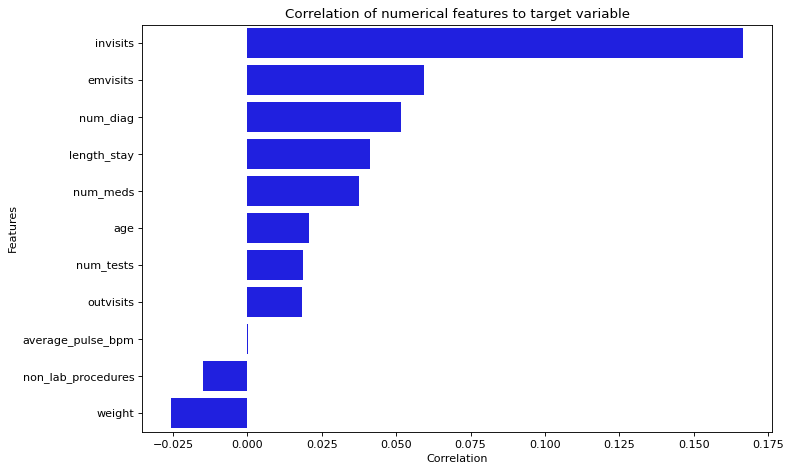

In [343]:
# Lets get the variables correlation to the target variable
correl = data[numerical_features+['readmitted_binary']].corr(method='pearson')['readmitted_binary'].sort_values(ascending=False)
correl.drop('readmitted_binary', inplace=True)

# Lets plot the correlation
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=correl.values, y=correl.index, color='b')
plt.title('Correlation of numerical features to target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

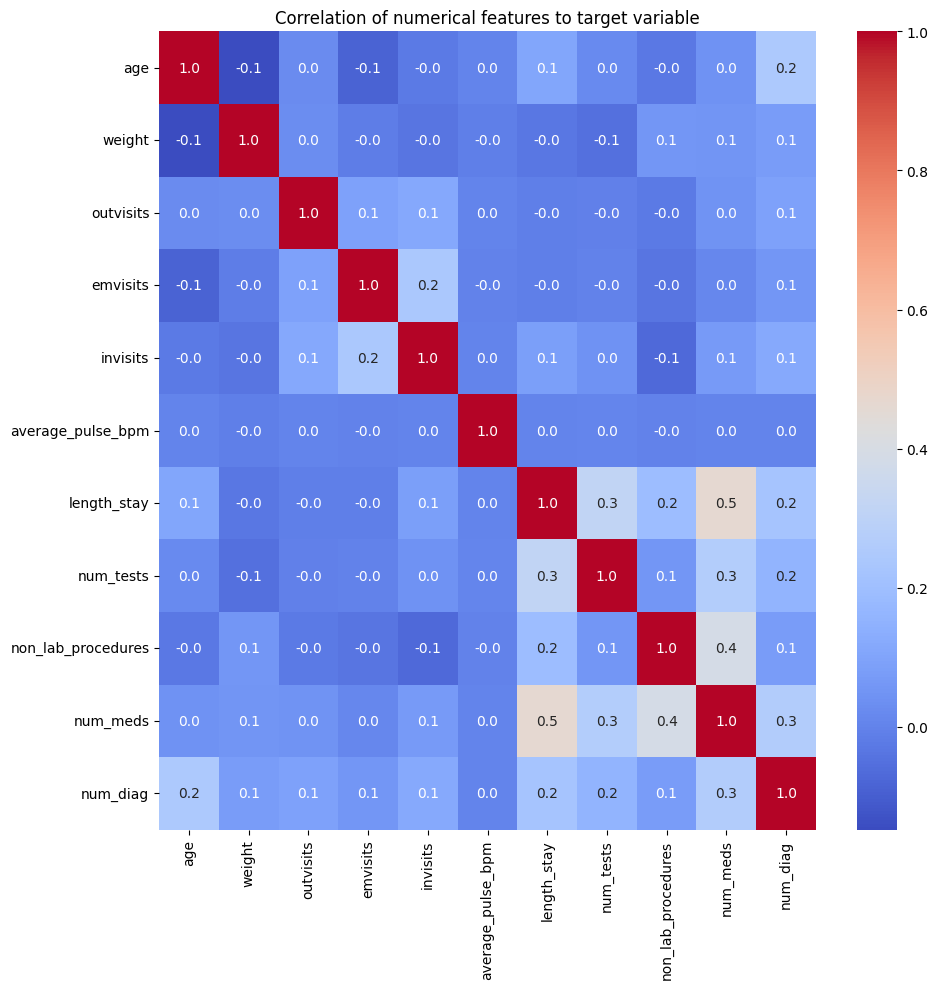

In [288]:
# Lets plot the heatmap of the correlation for the numerical features
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(data[numerical_features].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation of numerical features to target variable')
plt.tight_layout()
plt.show()

### __IV. Taking care of missing data__
Lets check for which values are missing (in percentage of the total dataframe size)

In [35]:
def get_missing_per(data):
    isna = (100 * data.isna().sum().sort_values(ascending=False) / len(data))
    isna = isna[isna != 0]

    missing_counts = 100 *data.apply(lambda x: x.value_counts().get('?', 0)).sort_values(ascending=False) / len(data)
    missing_counts = missing_counts[missing_counts != 0]

    # Remove the columns readmitted_binary and readmitted_multiclass, as these are the target variables
    isna = isna.drop(['readmitted_binary', 'readmitted_multiclass'])

    return pd.concat([isna, missing_counts], axis=0).sort_values(ascending=False)

get_missing_per(data)

admission_source                    6.663326
admission_type                      5.199182
age                                 4.999705
discharge_disposition               3.626948
additional_diagnosis_description    1.398306
additional_diagnosis                1.398306
secondary_diagnosis                 0.351787
secondary_diagnosis_description     0.351787
primary_diagnosis_description       0.020636
primary_diagnosis                   0.020636
dtype: float64

#### __0. Taking care of variables with high % of missing values__
We have many variables with a missing value count upwards of 30%, which should be removed. Lets check how they are, before removing them.

##### 1. *Weight*

In [235]:
data.groupby('weight', dropna=False)['readmitted_binary'].mean().sort_values(ascending=False)

weight
[0-25)       0.171429
[175-200)    0.142857
NaN          0.111697
[50-75)      0.111635
[100-125)    0.111359
[75-100)     0.109325
[25-50)      0.104478
[150-175)    0.095238
[125-150)    0.052083
>200         0.000000
Name: readmitted_binary, dtype: float64

In [21]:
data.groupby('weight')['prescribed_diabetes_meds'].mean().sort_values(ascending=False)

weight
>200         1.000000
[175-200)    0.909091
[0-25)       0.791667
[125-150)    0.765517
[150-175)    0.714286
[75-100)     0.694611
[100-125)    0.684800
[50-75)      0.665552
[25-50)      0.628866
Name: prescribed_diabetes_meds, dtype: float64

Although there seems to be some variance in the weight, with respect to the target variable, the missing values are too many to be imputed. We will remove this variable, as it might introduce bias in the model.

##### 2. *Glucose test results*

In [22]:
print(data.groupby('glucose_test_result')['readmitted_binary'].mean().sort_values(ascending=False))
print(data.groupby('a1c_test_result')['readmitted_binary'].mean().sort_values(ascending=False))

glucose_test_result
>300    0.142684
>200    0.130806
Norm    0.121816
Name: readmitted_binary, dtype: float64
a1c_test_result
>7      0.101551
Norm    0.099914
>8      0.096231
Name: readmitted_binary, dtype: float64


These two variables are very important to diagnose diabetes, and we can assume that if the test is Nan, it was not performed (probably because the patient was already known to be diabetic). We will impute the missing values with Not Performed.

We are also going to rename the columns to a1c_test_result and glucose_test_result, for better readability, and according to the following article:
<br> '*[A] diagnosis of diabetes can be made when the A1C exceeds 6.5% or when a random glycose level in a patient with classic symptoms exceeds 200 mg/dL.*' (https://www.ncbi.nlm.nih.gov/books/NBK551501/), meaning:
1. We can encode the a1c_test_result as 0 for 'Norma' and 1 for 'Abnormal', since the a1c values range from Norm, >7, >8. 
2. We will also use the glycose reading, with a threshold of >300mg/dL to encode it as 1, and 0 otherwise.
3. We can then join both dataframes, creating a new column name diabetes

In [23]:
glucose_map = {'Norm': 'Normal', '>200': 'Probably diabetic', '>300': 'Diabetic'}
a1c_map = {'Norm': 'Normal', '>7': 'Diabetic', '>8': 'Diabetic'}
data['glucose_test_result'] = data['glucose_test_result'].map(glucose_map).fillna('Not tested')
data['a1c_test_result'] = data['a1c_test_result'].map(a1c_map).fillna('Not tested')
print(data['glucose_test_result'].value_counts(), '\n')
print(data['a1c_test_result'].value_counts())

Not tested           96420
Normal                2597
Probably diabetic     1485
Diabetic              1264
Name: glucose_test_result, dtype: int64 

Not tested    84748
Diabetic      12028
Normal         4990
Name: a1c_test_result, dtype: int64


##### 3. *Medical specialty*

In [24]:
data.groupby('medical_specialty')['readmitted_binary'].mean().sort_values(ascending=False).head(5)

medical_specialty
0.0     0.500000
54.0    0.500000
38.0    0.250000
14.0    0.207547
15.0    0.202614
Name: readmitted_binary, dtype: float64

In [25]:
data[['medical_specialty','primary_diagnosis_description']].value_counts(dropna=False).head(10)

medical_specialty  primary_diagnosis_description                                                                               
NaN                Diabetes mellitus without mention of complication - type II or unspecified type - not stated as uncontrolled    4179
                   Congestive heart failure - unspecified                                                                          3552
                   Coronary atherosclerosis of unspecified type of vessel - native or graft                                        2821
                   Acute myocardial infarction of anterolateral wall - episode of care unspecified                                 1998
                   Respiratory abnormality - unspecified                                                                           1876
3.0                Coronary atherosclerosis of unspecified type of vessel - native or graft                                        1839
NaN                Pneumonia - organism unspecified     

Medical speciality is a tricky one. We have a lot of missing values, but it can explain some of the variance in the target variable. We could try to input the missing values with the help of the primary_diagnosis variable, but then we would just have the same data twice. We will remove this variable.

##### 4. *Insurance provider code*

In [26]:
data['payer_code'].value_counts(dropna=False).head(5)

NaN     40256
7.0     32439
6.0      6274
14.0     5007
0.0      4655
Name: payer_code, dtype: int64

In [27]:
data.groupby('payer_code')['readmitted_binary'].mean().sort_values(ascending=False).head(10)

payer_code
13.0    0.133333
9.0     0.129630
8.0     0.125201
7.0     0.118900
10.0    0.115226
4.0     0.108466
14.0    0.100537
6.0     0.097939
0.0     0.093864
3.0     0.089671
Name: readmitted_binary, dtype: float64

There doesn't seem to be enough explained variance in the target variable to justify the use of this variable. We will remove it.

##### 5. Removing variables mentioned above

In [28]:
data = data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, errors='ignore')

#### __1. Managing the variable race?__

In [36]:
get_missing_per(data)

admission_source                    6.663326
admission_type                      5.199182
age                                 4.999705
discharge_disposition               3.626948
additional_diagnosis_description    1.398306
additional_diagnosis                1.398306
secondary_diagnosis                 0.351787
secondary_diagnosis_description     0.351787
primary_diagnosis_description       0.020636
primary_diagnosis                   0.020636
dtype: float64

In [30]:
# Lets see how race is distributed
data.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
2.0,0.113665,50693
0.0,0.111321,12693
NaN,0.099803,5070
3.0,0.105572,1364
4.0,0.085427,995
1.0,0.095012,421


In [31]:
# Which variabels are most correlated to race 
corr = data.corr(method='pearson', numeric_only=True)
corr['race'].sort_values(ascending=False).head(5)

race                1.000000
patient_id          0.149978
age                 0.128719
number_diagnoses    0.067718
admission_type      0.045176
Name: race, dtype: float64

Race doesn't seem to be correlated to anything, so using a KNN algorithm doesn't make a lot of sense. Lets just use the most comun value to fill in the missing values. Although we will be introducing a bias, as the mean of the NaNs values for the target variable is different from the mean of class 2 (caucasian)

In [32]:
data['race'].fillna(2, inplace=True)

#### __2. Handling the admission variables__

- What are the admission_sources values? What about the admission types?

In [37]:
# Lets now check our isna() values again
get_missing_per(data)

admission_source                    6.663326
admission_type                      5.199182
age                                 4.999705
discharge_disposition               3.626948
additional_diagnosis_description    1.398306
additional_diagnosis                1.398306
secondary_diagnosis                 0.351787
secondary_diagnosis_description     0.351787
primary_diagnosis_description       0.020636
primary_diagnosis                   0.020636
dtype: float64

In [40]:
encoder_dict['admission_type'].classes_

array(['Elective', 'Emergency', 'Newborn', 'Not Available', 'Not Mapped',
       'Trauma Center', 'Urgent', nan], dtype=object)

In [38]:
print(data.groupby('admission_type', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))
print(data.groupby('admission_source', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))

                    mean  count
admission_type                 
1.0             0.114938  37742
6.0             0.112101  13024
NaN             0.109552   3706
3.0             0.106928   3320
0.0             0.103853  13211
4.0             0.088785    214
2.0             0.000000      6
5.0             0.000000     13
                      mean  count
admission_source                 
0.0               0.181818     11
13.0              0.155039    129
4.0               0.140187    107
8.0               0.127731    595
11.0              0.125000      8
1.0               0.116620  40319
NaN               0.106825   4718
12.0              0.105263    779
5.0               0.105184  20678
9.0               0.097311   1562
15.0              0.095964   2230
3.0               0.079545     88
6.0               0.000000      1
7.0               0.000000      2
10.0              0.000000      7
2.0               0.000000      1
14.0              0.000000      1


Lets use a predictive model to impute the Not Available values in admission_type and source. Before we do that, we need to encode the categorical variables.

Now for the KNN imputation, we need to encode all the categorical variables.

In [340]:
data.head(2).T

encounter_id,533253,426224
patient_id,70110,29775006
race,2.0,0.0
age,75.0,55.0
outpatient_visits_in_previous_year,0,0
emergency_visits_in_previous_year,0,0
inpatient_visits_in_previous_year,2,0
admission_type,1.0,1.0
average_pulse_bpm,127,128
discharge_disposition,1.0,4.0
admission_source,1.0,12.0


### __V. Feature engineering__
- Patient id is not very valuable as it is, but we can use it to create new features, such as the number of visits to the hospital. We just have to assume that the encounter id is sequencial, and that the patient id is unique.

In [230]:
a = data['inpatient_visits_in_previous_year']
a[a > 8] = 8

C:\Users\Mateus\AppData\Local\Temp\ipykernel_25364\2379980979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[a > 8] = 8


In [231]:
a.value_counts()

0    67630
1    19521
2     7566
3     3411
5     2016
4     1622
Name: inpatient_visits_in_previous_year, dtype: int64

In [232]:
a.corr(data['readmitted_binary'])

0.16323635158701308